本书之前的章节讲解了基于值函数的方法（DQN）和基于策略的方法（REINFORCE），
- 基于值函数的方法只学习一个价值函数
- 基于策略的方法只学习一个策略函数

**那么，一个很自然的问题是，有没有什么方法既学习价值函数，又学习策略函数呢？** 答案就是 Actor-Critic。

Actor-Critic 是囊括一系列算法的整体架构，目前很多高效的前沿算法都属于 Actor-Critic 算法，

本章接下来将会介绍一种最简单的 Actor-Critic 算法。

需要明确的是，**Actor-Critic 算法本质上是基于策略的算法**，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数，从而帮助策略函数更好地学习

在 REINFORCE 算法中，目标函数的梯度中有一项轨迹回报，用于指导策略的更新。
REINFOCE 算法用蒙特卡洛方法来估计Q(s,a)，能不能考虑拟合一个值函数来指导策略进行学习呢？这正是 Actor-Critic 算法所做的。


在策略梯度中，可以把梯度写成下面这个更加一般的形式：


In [1]:
from IPython.display import Image

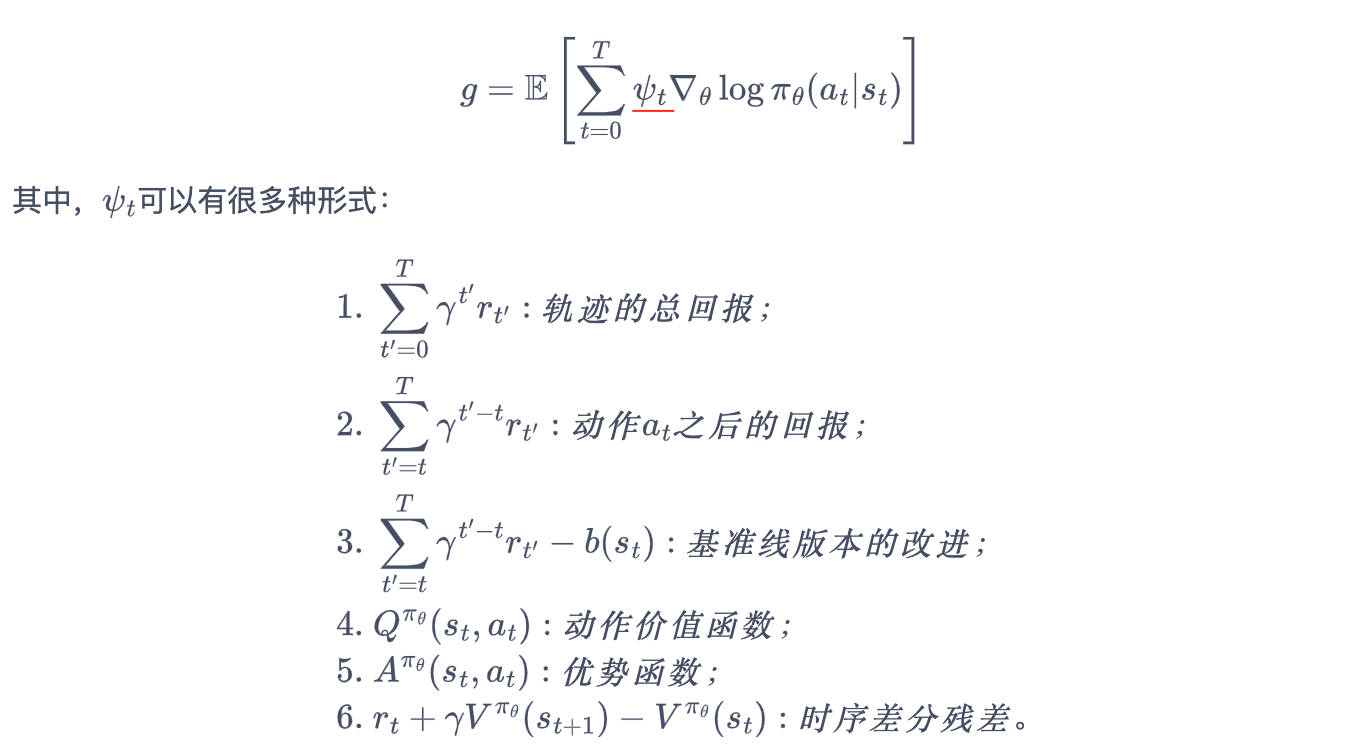

In [2]:
Image(filename='./step.png')

REINFORCE 通过蒙特卡洛采样的方法对策略梯度的估计是无偏的，但是方差非常大。

- 我们可以用 **形式(3)** 引入基线函数（baseline function）$b(s_t)$来减小方差。
- 我们也可以采用 Actor-Critic 算法估计一个动作价值函数Q，代替蒙特卡洛采样得到的回报，这便是 **形式(4)**
- 我们可以把状态价值函数$V$作为基线，从函数Q减去这个V函数则得到了A函数，我们称之为优势函数（advantage function），这便是 **形式(5)**
- 我们可以利用$Q = r + γV$等式得到**形式(6)**

**本章将着重介绍形式(6)，即通过时序差分残差$ψ_t = r_t + γV^π{(s_{t+1})} - V^π{(s_t)}$ 来指导策略梯度进行学习**。

事实上，用Q值 或者 V值本质上也是用奖励来进行指导，但是用神经网络进行估计的方法可以减小方差、提高鲁棒性。

除此之外，REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这同时也要求任务具有有限的步数，而 Actor-Critic 算法则可以在每一步之后都进行更新，并且不对任务的步数做限制。

我们将 Actor-Critic 分为两个部分：Actor（策略网络）和 Critic（价值网络）

- Actor 要做的是与环境交互，并在 **Critic 价值函数**的指导下用策略梯度学习一个更好的策略。
- Critic 要做的是通过 Actor 与环境交互收集的数据学习一个价值函数，这个价值函数会用于判断在当前状态什么动作是好的，什么动作不是好的，进而帮助 Actor 进行策略更新。

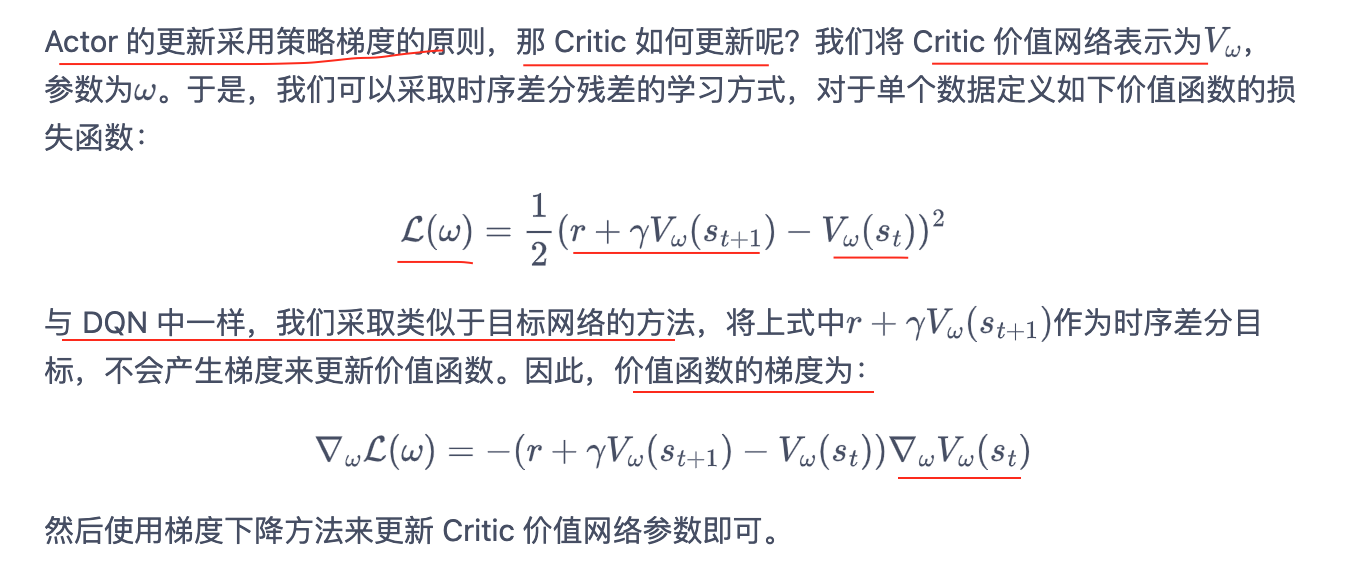

In [3]:
Image(filename='./ac.png')

## Actor-Critic代码实践


In [2]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [5]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

Actor-Critic 算法中额外引入一个价值网络，接下来的代码定义价值网络ValueNet，其输入是某个状态，输出则是状态的价值。

In [6]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

现在定义ActorCritic算法，主要包含采取动作（take_action()）和更新网络参数（update()）两个函数。

In [ ]:
class ActorCritic:
    def __init__(self,state_dim,hidden_dim,action_dim,actor_lr,critic_lr,gamma,device):
        # 策略网络
        self.actor = PolicyNet(state_dim,hidden_dim,action_dim).to(device)
        # 价值网络
        self.critic = ValueNet(state_dim,hidden_dim,action_dim)
        
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),actor_lr)
        # 价值网络优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),critic_lr)
        
        self.gamma = gamma
        self.device = device
    
    def take_action(self,state):
        state = torch.tensor([[state],dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    def update(self,transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)                      
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1,1).to(self.device)
        
        # TD目标
        td_target = rewards + self.gamma * self.critic(next_states)*(1-dones)
        # TD误差
        td_delta = td_target - self.critic(states)
        log_probs = torch.log(self.actor(states).gather(1,actions))
                              
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        critic_loss = torch.mean(F.mse_loss(self.critic(states),td_target.detach()))
                              
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
                              
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数
        

In [ ]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)

env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]

action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

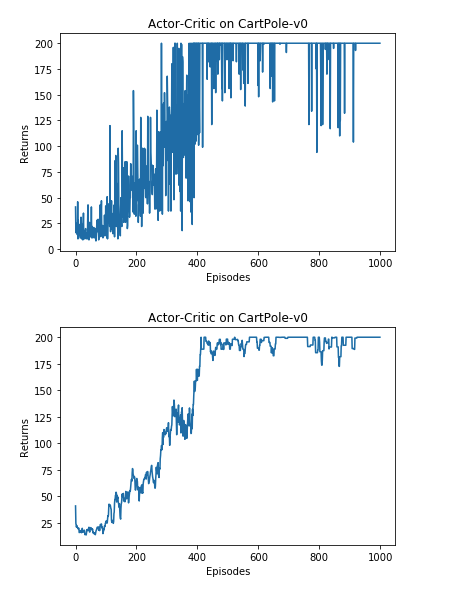

In [3]:
Image(filename="./ac_chart.png")

根据实验结果我们可以发现，
Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明价值函数的引入减小了方差。

本章讲解了 Actor-Critic 算法，它是基于值函数的方法和基于策略的方法的叠加。

价值模块 Critic 在策略模块 Actor 采样的数据中学习分辨什么是好的动作，什么不是好的动作，进而指导 Actor 进行策略更新。
随着 Actor 的训练的进行，其与环境交互所产生的数据分布也发生改变，这需要 Critic 尽快适应新的数据分布并给出好的判别。

Actor-Critic 算法非常实用，**后续章节中的 TRPO、PPO、DDPG、SAC 等深度强化学习算法都是在 Actor-Critic 框架下进行发展的**。

深入了解 Actor-Critic 算法对读懂目前深度强化学习的研究热点大有裨益。